In [1]:
import pandas as pd
import numpy as np
import prophet
import os
import warnings
import random
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import timedelta


d:\prophet\venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Importing plotly failed. Interactive plots will not work.


In [2]:
warnings.filterwarnings("ignore")
sns.set_style("darkgrid")
random.seed(42)
np.random.seed(42)

os.environ['PYTHONHASHSEED'] = str(42)


In [4]:
class suppress_stdout_stderr(object):
    """
    A context manager for doing a "deep suppression" of stdout and stderr in
    Python, i.e. will suppress all print, even if the print originates in a
    compiled C/Fortran sub-function.
       This will not suppress raised exceptions, since exceptions are printed
    to stderr just before a script exits, and after the context manager has
    exited (at least, I think that is why it lets exceptions through).

    """

    def __init__(self):
        # Open a pair of null files
        self.null_fds = [os.open(os.devnull, os.O_RDWR) for x in range(2)]
        # Save the actual stdout (1) and stderr (2) file descriptors.
        self.save_fds = (os.dup(1), os.dup(2))

    def __enter__(self):
        # Assign the null pointers to stdout and stderr.
        os.dup2(self.null_fds[0], 1)
        os.dup2(self.null_fds[1], 2)

    def __exit__(self, *_):
        # Re-assign the real stdout/stderr back to (1) and (2)
        os.dup2(self.save_fds[0], 1)
        os.dup2(self.save_fds[1], 2)
        # Close the null files
        os.close(self.null_fds[0])
        os.close(self.null_fds[1])

In [5]:
data = pd.read_csv("D:\prophet\Data\daily-website-visitors.csv")

In [6]:
data.head()

,Row,Day,Day.Of.Week,Date,Page.Loads,Unique.Visits,First.Time.Visits,Returning.Visits
0,1,Sunday,1,9/14/2014,"2,146","1,582","1,430",152
1,2,Monday,2,9/15/2014,"3,621","2,528","2,297",231
2,3,Tuesday,3,9/16/2014,"3,698","2,630","2,352",278
3,4,Wednesday,4,9/17/2014,"3,667","2,614","2,327",287
4,5,Thursday,5,9/18/2014,"3,316","2,366","2,130",236


In [7]:
data['ds'] = pd.to_datetime(data['Date'])
data = data.rename(columns={"Page.Loads":"y"})
data["y"] = data["y"].str.replace(",","").astype(float)
data = data[["ds","y"]]

In [8]:
data.head()

,ds,y
0,2014-09-14,2146.0
1,2014-09-15,3621.0
2,2014-09-16,3698.0
3,2014-09-17,3667.0
4,2014-09-18,3316.0


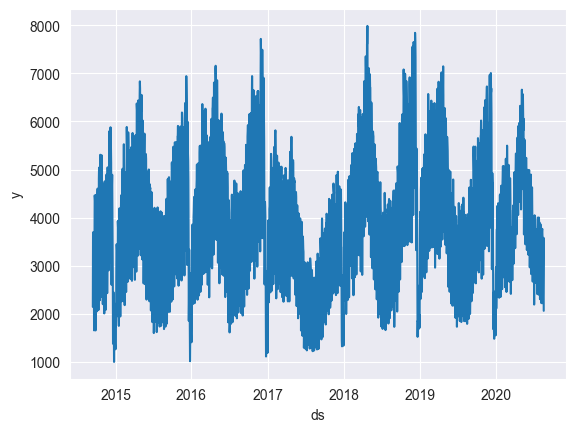

In [16]:
plt.Figure(figsize=(20,4))
sns.lineplot(data=data,x="ds",y="y")
# plt.xticks(rotation=90)
plt.show()

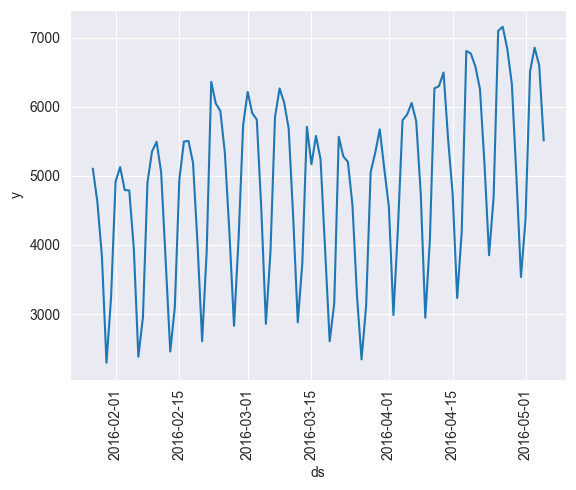

In [17]:
plt.Figure(figsize=(20,5))
sns.lineplot(data=data.iloc[500:600],x="ds",y="y")
plt.xticks(rotation=90)
plt.show()

In [18]:
ts = pd.date_range(start=data['ds'].min(),end=data['ds'].max(),freq="D")
len(ts)==len(data)

True

In [19]:
train_series = data[data.ds < (data.ds.max()-timedelta(days=30))].copy()
test_series = data[data.ds >= (data.ds.max()-timedelta(days=30))].copy()

Model

In [34]:
def draw_predictions(data: pd.DataFrame) -> None:
    series = data.set_index('ds').unstack().reset_index(drop=False)
    series.columns = ['type', 'ds', 'value']
    
    plt.figure(figsize=(20, 5))
    sns.lineplot(data=series, x='ds', y='value', hue='type')
    plt.xticks(rotation=90)
    plt.show()



Vanilla Prophet

In [22]:
import prophet
from sklearn.metrics import mean_squared_error,mean_absolute_percentage_error



In [23]:
prophet.diagnostics.logging.disable(level=50)

fb = prophet.Prophet()
with suppress_stdout_stderr():
    fb.fit(train_series)

In [24]:
predictions = fb.make_future_dataframe(periods=len(test_series),freq="D")
forecast = fb.predict(predictions)

In [25]:
forecast.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2014-09-14,3341.200208,1478.200562,2690.562852,3341.200208,3341.200208,-1280.730510,-1280.730510,-1280.730510,-872.543058,-872.543058,-872.543058,-408.187452,-408.187452,-408.187452,0.0,0.0,0.0,2060.469698
1,2014-09-15,3344.309765,3086.112108,4352.666958,3344.309765,3344.309765,374.576691,374.576691,374.576691,734.251752,734.251752,734.251752,-359.675061,-359.675061,-359.675061,0.0,0.0,0.0,3718.886455
2,2014-09-16,3347.419321,3251.635906,4502.762709,3347.419321,3347.419321,533.713903,533.713903,533.713903,845.430276,845.430276,845.430276,-311.716373,-311.716373,-311.716373,0.0,0.0,0.0,3881.133224
3,2014-09-17,3350.528878,3298.920331,4492.787396,3350.528878,3350.528878,522.302806,522.302806,522.302806,787.160742,787.160742,787.160742,-264.857936,-264.857936,-264.857936,0.0,0.0,0.0,3872.831684
4,2014-09-18,3353.638435,3066.485289,4263.452883,3353.638435,3353.638435,315.152713,315.152713,315.152713,534.763769,534.763769,534.763769,-219.611056,-219.611056,-219.611056,0.0,0.0,0.0,3668.791147


In [26]:
forecast.columns

Index(['ds', 'trend', 'yhat_lower', 'yhat_upper', 'trend_lower', 'trend_upper',
       'additive_terms', 'additive_terms_lower', 'additive_terms_upper',
       'weekly', 'weekly_lower', 'weekly_upper', 'yearly', 'yearly_lower',
       'yearly_upper', 'multiplicative_terms', 'multiplicative_terms_lower',
       'multiplicative_terms_upper', 'yhat'],
      dtype='object')

In [37]:
result_df = test_series.copy()
result_df = result_df.merge(forecast[['ds','yhat']],on='ds',how='left')

In [40]:
np.sqrt(mean_squared_error(result_df['y'],result_df['yhat']))

np.float64(512.9158099283045)

In [41]:
mean_absolute_percentage_error(result_df['y'],result_df['yhat'])

0.1362703844129066

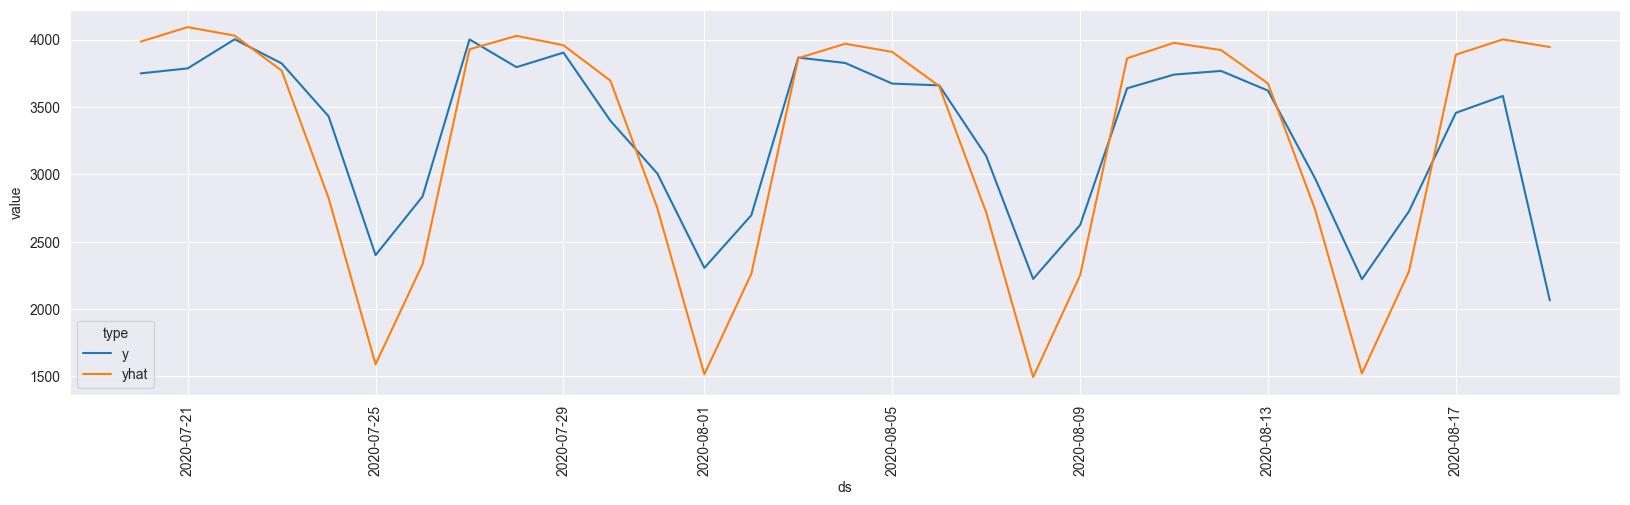

In [39]:
draw_predictions(result_df)

In [42]:
forecast.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2014-09-14,3341.200208,1478.200562,2690.562852,3341.200208,3341.200208,-1280.730510,-1280.730510,-1280.730510,-872.543058,-872.543058,-872.543058,-408.187452,-408.187452,-408.187452,0.0,0.0,0.0,2060.469698
1,2014-09-15,3344.309765,3086.112108,4352.666958,3344.309765,3344.309765,374.576691,374.576691,374.576691,734.251752,734.251752,734.251752,-359.675061,-359.675061,-359.675061,0.0,0.0,0.0,3718.886455
2,2014-09-16,3347.419321,3251.635906,4502.762709,3347.419321,3347.419321,533.713903,533.713903,533.713903,845.430276,845.430276,845.430276,-311.716373,-311.716373,-311.716373,0.0,0.0,0.0,3881.133224
3,2014-09-17,3350.528878,3298.920331,4492.787396,3350.528878,3350.528878,522.302806,522.302806,522.302806,787.160742,787.160742,787.160742,-264.857936,-264.857936,-264.857936,0.0,0.0,0.0,3872.831684
4,2014-09-18,3353.638435,3066.485289,4263.452883,3353.638435,3353.638435,315.152713,315.152713,315.152713,534.763769,534.763769,534.763769,-219.611056,-219.611056,-219.611056,0.0,0.0,0.0,3668.791147


In [43]:
result_df.head()

,ds,y,yhat
0,2020-07-20,3749.0,3984.430675
1,2020-07-21,3786.0,4092.465717
2,2020-07-22,4002.0,4028.920576
3,2020-07-23,3823.0,3769.361170
4,2020-07-24,3430.0,2823.207566


Prophet+LGBM+OPTUNA

In [50]:
import optuna
import optuna_integration.lightgbm as lgb   
from optuna_integration.lightgbm import Dataset



ImportError: cannot import name 'Dataset' from 'optuna_integration.lightgbm' (d:\prophet\venv\lib\site-packages\optuna_integration\lightgbm\__init__.py)